**Objective**: In this lab, you will implement and compare manual grid search with scikit-learn's built-in GridSearchCV for hyperparameter tuning. You'll work with multiple classification algorithms and combine them using voting classifiers.

**Learning Goals**:
- Understand hyperparameter tuning through grid search
- Compare manual implementation with built-in functions
- Learn to create and evaluate voting classifiers
- Work with multiple real-world datasets
- Visualize model performance using ROC curves and confusion matrices

**Datasets Used**:
1. Wine Quality - Predicting wine quality based on chemical properties
2. HR Attrition - Predicting employee turnover
3. Banknote Authentication - Detecting counterfeit banknotes
4. QSAR Biodegradation - Predicting chemical biodegradability



## Part 1: Import Libraries and Setup

First, let's import all the necessary libraries for our machine learning pipeline.

In [74]:
!pip install scikit-learn pandas numpy matplotlib

In [75]:
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, roc_curve,
                             confusion_matrix, ConfusionMatrixDisplay, classification_report)
# Bypass SSL certificate verification for dataset downloads
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

# Models and Parameter Grids

In [76]:
# The parameter names must match the pipeline step names, e.g., 'classifier__max_depth'
# ToDo: Define base models (Decision Tree, kNN, Logistic Regression)

param_grid_dt = {
    'classifier__max_depth': [3,5,9, None],
    'classifier__min_samples_split': [4,8,10],
    "classifier__criterion": ["gini", "entropy"]
}

param_grid_knn = {
    'classifier__n_neighbors': [2,4,6,8],
    'classifier__weights': ['uniform', 'distance'],
    'classifier__p': [1,2]
}

param_grid_lr = {
    'classifier__C': [0.05,0.5,2,5],
    'classifier__penalty': ['l2'],
    'classifier__solver': ['lbfgs', 'saga'],
    'classifier__max_iter': [500]
}

# ToDo: Create a list of (classifier, param_grid, name) tuples
classifiers_to_tune = [
    (DecisionTreeClassifier(random_state=42), param_grid_dt, "Decision Tree"),
    (KNeighborsClassifier(), param_grid_knn, "kNN"),
    (LogisticRegression(random_state=42), param_grid_lr, "Logistic Regression")
]


## Dataset Loading Functions
We'll work with four different datasets to test our algorithms across various domains.

### 3.1 Wine Quality Dataset


In [77]:
def load_wine_quality():
    """Load Wine Quality dataset"""
    url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv'
    try:
        data = pd.read_csv(url, sep=';')
    except Exception as e:
        print(f"Error loading Wine Quality dataset: {e}")
        return None, None, None, None, "Wine Quality (Failed)"

    # Create the binary target variable 'good_quality'
    data['good_quality'] = (data['quality'] > 5).astype(int)
    X = data.drop(['quality', 'good_quality'], axis=1)
    y = data['good_quality']

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )

    print("Wine Quality dataset loaded and preprocessed successfully.")
    print(f"Training set shape: {X_train.shape}")
    print(f"Testing set shape: {X_test.shape}")
    return X_train, X_test, y_train, y_test, "Wine Quality"

### 3.2 HR Attrition Dataset


In [ ]:
def load_hr_attrition():
    """Load IBM HR Attrition dataset"""
    try:
        data = pd.read_csv("data/WA_Fn-UseC_-HR-Employee-Attrition.csv")
    except FileNotFoundError:
        print("HR Attrition dataset not found. Please place 'WA_Fn-UseC_-HR-Employee-Attrition.csv' inside a 'data/' folder.")
        return None, None, None, None, "HR Attrition (Failed)"

    # Target: Attrition = Yes (1), No (0)
    data['Attrition'] = (data['Attrition'] == 'Yes').astype(int)

    # Drop ID-like column
    X = data.drop(['EmployeeNumber', 'Attrition'], axis=1, errors='ignore')
    y = data['Attrition']

    # One-hot encode categorical variables
    X = pd.get_dummies(X, drop_first=True)

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, stratify=y, test_size=0.3, random_state=42
    )

    print("IBM HR Attrition dataset loaded and preprocessed successfully.")
    print(f"Training set shape: {X_train.shape}")
    print(f"Testing set shape: {X_test.shape}")
    return X_train, X_test, y_train, y_test, "HR Attrition"

### 3.3 Banknote Authentication Dataset



In [79]:
def load_banknote():
    """Load Banknote Authentication dataset"""
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00267/data_banknote_authentication.txt"

    try:
        data = pd.read_csv(url, header=None)
    except Exception as e:
        print(f"Error loading Banknote dataset: {e}")
        return None, None, None, None, "Banknote (Failed)"

    # According to UCI: variance, skewness, curtosis, entropy, class (0=authentic, 1=fake)
    X = data.iloc[:, :-1]
    y = data.iloc[:, -1]

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, stratify=y, test_size=0.3, random_state=42
    )

    print("Banknote Authentication dataset loaded successfully.")
    print(f"Training set shape: {X_train.shape}")
    print(f"Testing set shape: {X_test.shape}")
    return X_train, X_test, y_train, y_test, "Banknote Authentication"


### 3.4 QSAR Biodegradation Dataset





In [80]:
def load_qsar_biodegradation():
    """Load QSAR Biodegradation dataset"""
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00254/biodeg.csv"

    try:
        data = pd.read_csv(url, sep=';', header=None)
    except Exception as e:
        print(f"Error loading QSAR dataset: {e}")
        return None, None, None, None, "QSAR (Failed)"

    # Last column is target (RB = ready biodegradable, NRB = not)
    X = data.iloc[:, :-1]
    y = (data.iloc[:, -1] == 'RB').astype(int)

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, stratify=y, test_size=0.3, random_state=42
    )

    print("QSAR Biodegradation dataset loaded successfully.")
    print(f"Training set shape: {X_train.shape}")
    print(f"Testing set shape: {X_test.shape}")
    return X_train, X_test, y_train, y_test, "QSAR Biodegradation"

## Part 4: Manual Grid Search Implementation



In [81]:
from sklearn.model_selection import ParameterGrid

def run_manual_grid_search(X_train, y_train, dataset_name):
    """Run manual grid search and return best estimators"""
    print(f"\n{'='*60}")
    print(f"RUNNING MANUAL GRID SEARCH FOR {dataset_name.upper()}")
    print(f"{'='*60}")

    best_estimators = {}
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Adjust parameter grids based on dataset size
    n_features = X_train.shape[1]

    for classifier_instance, param_grid, name in classifiers_to_tune:
        print(f"--- Manual Grid Search for {name} ---")
        best_score = -1
        best_params = None

        # TODO: Implement manual grid search for hyperparameter tuning.
        # Steps to implement:
        # 1. Adjust the feature selection parameter grid to ensure 'k' does not exceed the number of features.
        # 2. Generate all combinations of hyperparameters from the adjusted parameter grid.
        # 3. For each parameter combination:
        #    a. Perform cross-validation (e.g., 5-fold StratifiedKFold).
        #    b. For each fold:
        #       i. Split the training data into training and validation sets.
        #       ii. Build a pipeline with scaling, feature selection, and the classifier.
        #       iii. Set the pipeline parameters for the current combination.
        #       iv. Fit the pipeline on the training fold.
        #       v. Predict probabilities on the validation fold.
        #       vi. Compute the AUC score for the fold.
        #    c. Compute the mean AUC across all folds for the parameter combination.
        #    d. Track and print the best parameter combination and its mean AUC.


        adjusted_param_grid = param_grid.copy()
        adjusted_param_grid["feature_selection__k"] = list(
            range(1, min(n_features, 11))
        )

        param_names = list(adjusted_param_grid.keys())
        param_combinations = list(itertools.product(
            *[adjusted_param_grid[p] for p in param_names]
        ))

        for param_values in param_combinations:
            params = dict(zip(param_names, param_values))
            cvscores = []

            for train_idx, val_idx in cv.split(X_train, y_train):
                X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
                y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

                pipe = Pipeline(steps=[
                    ('scaler', StandardScaler()),
                    ('feature_selection', SelectKBest(f_classif)),
                    ('classifier', classifier_instance)
                ])

                pipe.set_params(**params)

                pipe.fit(X_tr, y_tr)

                if hasattr(pipe, "predict_proba"):
                    y_proba = pipe.predict_proba(X_val)[:, 1]
                else:
                    y_proba = pipe.decision_function(X_val)

                auc = roc_auc_score(y_val, y_proba)
                cvscores.append(auc)

            mean_auc = np.mean(cvscores)

            if mean_auc > best_score:
                best_score = mean_auc
                best_params = params


        # Create the final pipeline for this classifier
        print("-" * 90)
        print(f"Best parameters for {name}: {best_params}")
        print(f"Best cross-validation AUC: {best_score:.4f}")

        final_pipeline = Pipeline(steps=[
            ('scaler', StandardScaler()),
            ('feature_selection', SelectKBest(f_classif)),
            ('classifier', classifier_instance)
        ])

        # Set the best parameters found
        final_pipeline.set_params(**best_params)

        # Fit the final pipeline on the full training data
        final_pipeline.fit(X_train, y_train)

        # Store the fully trained best pipeline
        best_estimators[name] = final_pipeline

    return best_estimators

**Understanding the Manual Implementation**:
- **Nested Cross-Validation**: For each parameter combination, we perform 5-fold CV
- **Pipeline Integration**: Each step (scaling, feature selection, classification) is properly chained
- **AUC Scoring**: We use Area Under the ROC Curve as our optimization metric
- **Best Model Selection**: The combination with highest mean AUC across folds is selected

## Part 5: Built-in Grid Search Implementation

Now let's compare our manual implementation with scikit-learn's GridSearchCV.



**Advantages of Built-in GridSearchCV**:
- **Parallel Processing**: Uses `n_jobs=-1` for faster computation
- **Cleaner Code**: Less verbose than manual implementation
- **Built-in Features**: Automatic best model selection and scoring


In [ ]:
from sklearn.metrics import make_scorer, roc_auc_score
from sklearn.feature_selection import VarianceThreshold

def run_builtin_grid_search(X_train, y_train, dataset_name):
    """Run built-in grid search and return best estimators"""
    print(f"\n{'='*60}")
    print(f"RUNNING BUILT-IN GRID SEARCH FOR {dataset_name.upper()}")
    print(f"{'='*60}")

    results_builtin = {}

    # Adjust parameter grids based on dataset size
    n_features = X_train.shape[1]

    for classifier_instance, param_grid, name in classifiers_to_tune:
        print(f"\n--- GridSearchCV for {name} ---")

        # TODO: Implement built-in grid search for each classifier:
        # - Adjust feature selection parameter grid based on dataset size (n_features)
        # - Create a pipeline with StandardScaler, SelectKBest(f_classif), and the classifier
        # - Set up StratifiedKFold cross-validation
        # - Run GridSearchCV with the pipeline and adjusted param grid
        # - Fit grid search on training data and collect best estimator/results

        # Example code fragments that may be needed:
        # n_features = X_train.shape[1]
        # pipeline = Pipeline(steps=[
        #     ('scaler', StandardScaler()),
        #     ('feature_selection', SelectKBest(f_classif)),
        #     ('classifier', classifier_instance)
        # ])
        # cv_splitter = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

        adjusted_param_grid = param_grid.copy()
        adjusted_param_grid["feature_selection__k"] = list(
            range(1, min(n_features, 11))
        )

        pipeline = Pipeline(steps=[
          ('scaler', StandardScaler()),
          ('feature_selection', SelectKBest(f_classif)),
          ('classifier', classifier_instance)
        ])

        cv_splitter = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

        grid_search = GridSearchCV(
            estimator=pipeline,
            param_grid=adjusted_param_grid,
            cv=cv_splitter,
            scoring="accuracy",
            n_jobs=-1,
            verbose=0
        )

        grid_search.fit(X_train, y_train)



        # Save results
        results_builtin[name] = {
            'best_estimator': grid_search.best_estimator_,
            'best_score (CV)': grid_search.best_score_,
            'best_params': grid_search.best_params_
        }
        print(f"Best params for {name}: {results_builtin[name]['best_params']}")
        print(f"Best CV score: {results_builtin[name]['best_score (CV)']:.4f}")

    return results_builtin

## Part 6: Model Evaluation and Voting Classifiers

This function evaluates individual models and creates voting classifiers to combine their predictions.




In [83]:
def evaluate_models(X_test, y_test, best_estimators, dataset_name, method_name="Manual"):
    """Evaluate models and create visualizations"""
    print(f"\n{'='*60}")
    print(f"EVALUATING {method_name.upper()} MODELS FOR {dataset_name.upper()}")
    print(f"{'='*60}")

    # Individual model evaluation
    print(f"\n--- Individual Model Performance ---")
    for name, model in best_estimators.items():
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        print(f"\n{name}:")
        print(f"  Accuracy: {accuracy_score(y_test, y_pred):.4f}")
        print(f"  Precision: {precision_score(y_test, y_pred, zero_division=0):.4f}")
        print(f"  Recall: {recall_score(y_test, y_pred, zero_division=0):.4f}")
        print(f"  F1-Score: {f1_score(y_test, y_pred, zero_division=0):.4f}")
        print(f"  ROC AUC: {roc_auc_score(y_test, y_pred_proba):.4f}")

    # Voting Classifier
    print(f"\n--- {method_name} Voting Classifier ---")

    if method_name == "Manual":
        # Manual voting implementation
        y_pred_votes = []
        y_pred_proba_avg = []

        for i in range(len(X_test)):
            votes = []
            probas = []

            for name, model in best_estimators.items():
                pred = model.predict(X_test.iloc[[i]])[0]
                proba = model.predict_proba(X_test.iloc[[i]])[0, 1]
                votes.append(pred)
                probas.append(proba)

            majority_vote = 1 if np.mean(votes) > 0.5 else 0
            avg_proba = np.mean(probas)

            y_pred_votes.append(majority_vote)
            y_pred_proba_avg.append(avg_proba)

        y_pred_votes = np.array(y_pred_votes)
        y_pred_proba_avg = np.array(y_pred_proba_avg)

    else:  # Built-in
        # Create VotingClassifier
        estimators = [(name, model) for name, model in best_estimators.items()]
        voting_clf = VotingClassifier(estimators=estimators, voting='soft')
        voting_clf.fit(X_train, y_train)  # Note: This assumes X_train, y_train are in scope

        y_pred_votes = voting_clf.predict(X_test)
        y_pred_proba_avg = voting_clf.predict_proba(X_test)[:, 1]

    # Compute voting metrics
    accuracy = accuracy_score(y_test, y_pred_votes)
    precision = precision_score(y_test, y_pred_votes, zero_division=0)
    recall = recall_score(y_test, y_pred_votes, zero_division=0)
    f1 = f1_score(y_test, y_pred_votes, zero_division=0)
    auc = roc_auc_score(y_test, y_pred_proba_avg)

    print(f"Voting Classifier Performance:")
    print(f"  Accuracy: {accuracy:.4f}, Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}, F1: {f1:.4f}, AUC: {auc:.4f}")

    # Visualizations
    # ROC Curves
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    for name, model in best_estimators.items():
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        auc_score = roc_auc_score(y_test, y_pred_proba)
        plt.plot(fpr, tpr, label=f'{name} (AUC = {auc_score:.3f})')

    # Add voting classifier to ROC
    fpr_vote, tpr_vote, _ = roc_curve(y_test, y_pred_proba_avg)
    plt.plot(fpr_vote, tpr_vote, label=f'Voting (AUC = {auc:.3f})', linewidth=3, linestyle='--')

    plt.plot([0, 1], [0, 1], 'k--', label='Chance')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curves - {dataset_name} ({method_name})')
    plt.legend()
    plt.grid(True)

    # Confusion Matrix for Voting Classifier
    plt.subplot(1, 2, 2)
    cm = confusion_matrix(y_test, y_pred_votes)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=plt.gca(), cmap="Blues")
    plt.title(f'Voting Classifier - {dataset_name} ({method_name})')

    plt.tight_layout()
    plt.show()

    return y_pred_votes, y_pred_proba_avg

## Part 7: Complete Pipeline Function

This function orchestrates the entire experiment for each dataset.



In [84]:
def run_complete_pipeline(dataset_loader, dataset_name):
    """Run complete pipeline for a dataset"""
    print(f"\n{'#'*80}")
    print(f"PROCESSING DATASET: {dataset_name.upper()}")
    print(f"{'#'*80}")

    # Load dataset
    X_train, X_test, y_train, y_test, actual_name = dataset_loader()
    if X_train is None:
        print(f"Skipping {dataset_name} due to loading error.")
        return

    print("-" * 30)

    # Part 1: Manual Implementation
    manual_estimators = run_manual_grid_search(X_train, y_train, actual_name)
    manual_votes, manual_proba = evaluate_models(X_test, y_test, manual_estimators, actual_name, "Manual")

    # Part 2: Built-in Implementation
    builtin_results = run_builtin_grid_search(X_train, y_train, actual_name)
    builtin_estimators = {name: results['best_estimator']
                         for name, results in builtin_results.items()}
    builtin_votes, builtin_proba = evaluate_models(X_test, y_test, builtin_estimators, actual_name, "Built-in")

    print(f"\nCompleted processing for {actual_name}")
    print("="*80)

## Part 8: Execute the Complete Lab

Now let's run our pipeline on all four datasets!




################################################################################
PROCESSING DATASET: WINE QUALITY
################################################################################
Wine Quality dataset loaded and preprocessed successfully.
Training set shape: (1119, 11)
Testing set shape: (480, 11)
------------------------------

RUNNING MANUAL GRID SEARCH FOR WINE QUALITY
--- Manual Grid Search for Decision Tree ---
------------------------------------------------------------------------------------------
Best parameters for Decision Tree: {'classifier__max_depth': 5, 'classifier__min_samples_split': 10, 'classifier__criterion': 'entropy', 'feature_selection__k': 4}
Best cross-validation AUC: 0.7896
--- Manual Grid Search for kNN ---
------------------------------------------------------------------------------------------
Best parameters for kNN: {'classifier__n_neighbors': 8, 'classifier__weights': 'distance', 'classifier__p': 1, 'feature_selection__k': 4}
Best cross-

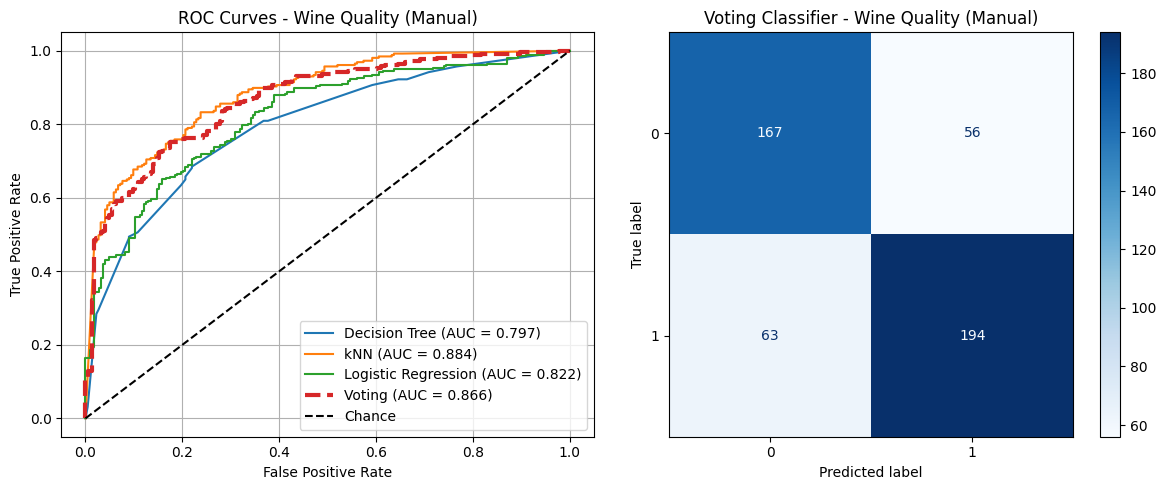


RUNNING BUILT-IN GRID SEARCH FOR WINE QUALITY

--- GridSearchCV for Decision Tree ---
Best params for Decision Tree: {'classifier__criterion': 'entropy', 'classifier__max_depth': None, 'classifier__min_samples_split': 4, 'feature_selection__k': 7}
Best CV score: 0.7471

--- GridSearchCV for kNN ---
Best params for kNN: {'classifier__n_neighbors': 6, 'classifier__p': 1, 'classifier__weights': 'distance', 'feature_selection__k': 4}
Best CV score: 0.7909

--- GridSearchCV for Logistic Regression ---
Best params for Logistic Regression: {'classifier__C': 0.05, 'classifier__max_iter': 500, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs', 'feature_selection__k': 8}
Best CV score: 0.7426

EVALUATING BUILT-IN MODELS FOR WINE QUALITY

--- Individual Model Performance ---

Decision Tree:
  Accuracy: 0.7458
  Precision: 0.7778
  Recall: 0.7354
  F1-Score: 0.7560
  ROC AUC: 0.7504

kNN:
  Accuracy: 0.7896
  Precision: 0.8023
  Recall: 0.8054
  F1-Score: 0.8039
  ROC AUC: 0.8788

Logist

/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [ 4 16] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [ 4 16] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [ 4 16] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/l

------------------------------------------------------------------------------------------
Best parameters for Decision Tree: {'classifier__max_depth': 5, 'classifier__min_samples_split': 10, 'classifier__criterion': 'entropy', 'feature_selection__k': 9}
Best cross-validation AUC: 0.7250
--- Manual Grid Search for kNN ---


/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [ 4 16] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [ 4 16] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [ 4 16] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/l

------------------------------------------------------------------------------------------
Best parameters for kNN: {'classifier__n_neighbors': 8, 'classifier__weights': 'distance', 'classifier__p': 2, 'feature_selection__k': 10}
Best cross-validation AUC: 0.7175
--- Manual Grid Search for Logistic Regression ---


/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [ 4 16] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [ 4 16] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [ 4 16] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/l

------------------------------------------------------------------------------------------
Best parameters for Logistic Regression: {'classifier__C': 5, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs', 'classifier__max_iter': 500, 'feature_selection__k': 10}
Best cross-validation AUC: 0.7530

EVALUATING MANUAL MODELS FOR HR ATTRITION

--- Individual Model Performance ---

Decision Tree:
  Accuracy: 0.8345
  Precision: 0.4706
  Recall: 0.2254
  F1-Score: 0.3048
  ROC AUC: 0.6864

kNN:
  Accuracy: 0.8209
  Precision: 0.4048
  Recall: 0.2394
  F1-Score: 0.3009
  ROC AUC: 0.7198

Logistic Regression:
  Accuracy: 0.8435
  Precision: 0.5385
  Recall: 0.1972
  F1-Score: 0.2887
  ROC AUC: 0.7599

--- Manual Voting Classifier ---
Voting Classifier Performance:
  Accuracy: 0.8367, Precision: 0.4848
  Recall: 0.2254, F1: 0.3077, AUC: 0.7592


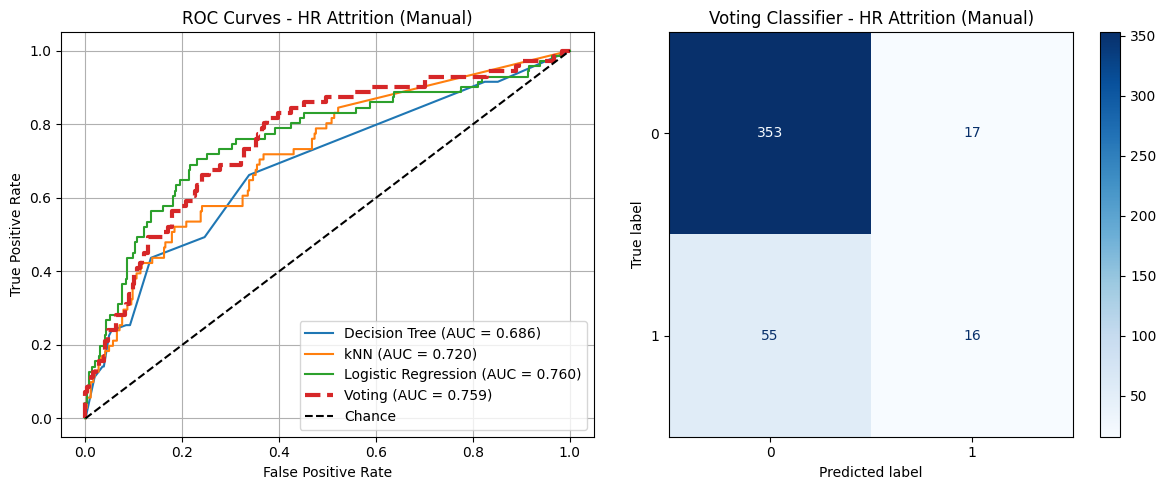


RUNNING BUILT-IN GRID SEARCH FOR HR ATTRITION

--- GridSearchCV for Decision Tree ---


/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [ 4 16] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Best params for Decision Tree: {'classifier__criterion': 'gini', 'classifier__max_depth': 3, 'classifier__min_samples_split': 4, 'feature_selection__k': 8}
Best CV score: 0.8542

--- GridSearchCV for kNN ---


/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [ 4 16] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Best params for kNN: {'classifier__n_neighbors': 8, 'classifier__p': 1, 'classifier__weights': 'distance', 'feature_selection__k': 10}
Best CV score: 0.8669

--- GridSearchCV for Logistic Regression ---


/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [ 4 16] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Best params for Logistic Regression: {'classifier__C': 0.05, 'classifier__max_iter': 500, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs', 'feature_selection__k': 10}
Best CV score: 0.8513

EVALUATING BUILT-IN MODELS FOR HR ATTRITION

--- Individual Model Performance ---

Decision Tree:
  Accuracy: 0.8209
  Precision: 0.3000
  Recall: 0.0845
  F1-Score: 0.1319
  ROC AUC: 0.7028

kNN:
  Accuracy: 0.8277
  Precision: 0.4359
  Recall: 0.2394
  F1-Score: 0.3091
  ROC AUC: 0.7176

Logistic Regression:
  Accuracy: 0.8481
  Precision: 0.5909
  Recall: 0.1831
  F1-Score: 0.2796
  ROC AUC: 0.7623

--- Built-in Voting Classifier ---
Error processing HR Attrition: name 'X_train' is not defined

################################################################################
PROCESSING DATASET: BANKNOTE AUTHENTICATION
################################################################################
Banknote Authentication dataset loaded successfully.
Training set shape: (960, 4)
Testing 

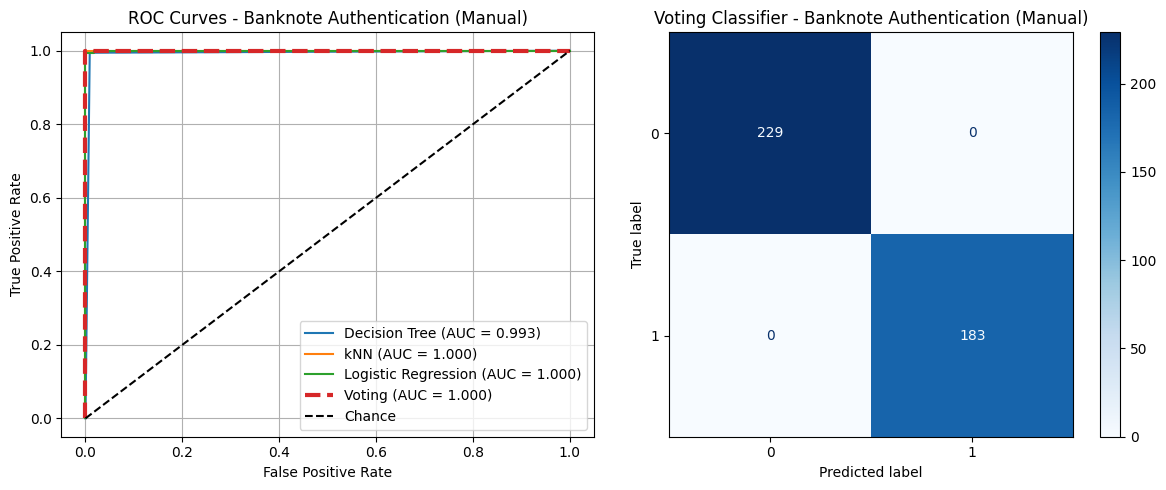


RUNNING BUILT-IN GRID SEARCH FOR BANKNOTE AUTHENTICATION

--- GridSearchCV for Decision Tree ---
Best params for Decision Tree: {'classifier__criterion': 'entropy', 'classifier__max_depth': 9, 'classifier__min_samples_split': 4, 'feature_selection__k': 3}
Best CV score: 0.9927

--- GridSearchCV for kNN ---
Best params for kNN: {'classifier__n_neighbors': 2, 'classifier__p': 1, 'classifier__weights': 'uniform', 'feature_selection__k': 3}
Best CV score: 0.9990

--- GridSearchCV for Logistic Regression ---
Best params for Logistic Regression: {'classifier__C': 2, 'classifier__max_iter': 500, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs', 'feature_selection__k': 3}
Best CV score: 0.9844

EVALUATING BUILT-IN MODELS FOR BANKNOTE AUTHENTICATION

--- Individual Model Performance ---

Decision Tree:
  Accuracy: 0.9927
  Precision: 0.9891
  Recall: 0.9945
  F1-Score: 0.9918
  ROC AUC: 0.9929

kNN:
  Accuracy: 1.0000
  Precision: 1.0000
  Recall: 1.0000
  F1-Score: 1.0000
  ROC AUC:

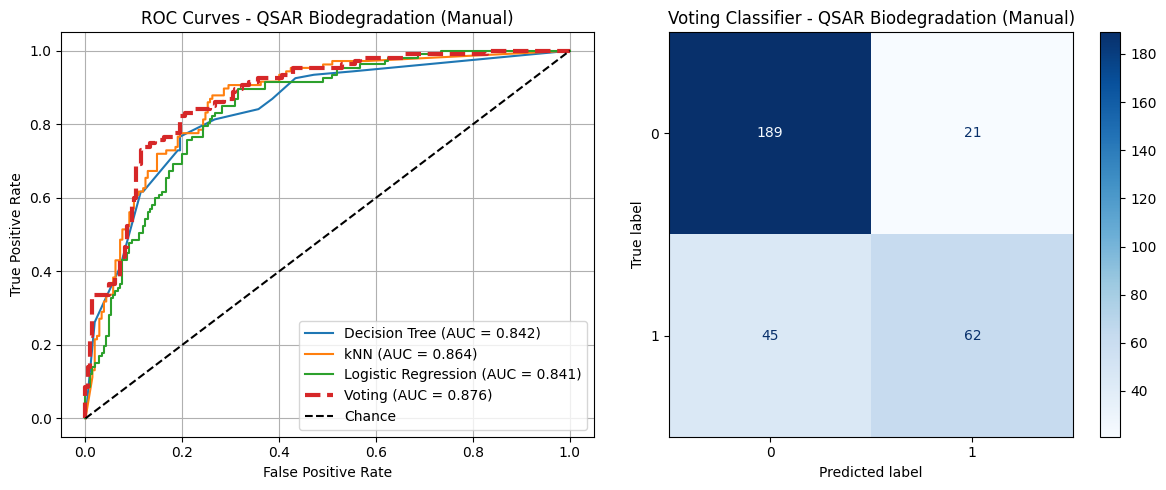


RUNNING BUILT-IN GRID SEARCH FOR QSAR BIODEGRADATION

--- GridSearchCV for Decision Tree ---
Best params for Decision Tree: {'classifier__criterion': 'entropy', 'classifier__max_depth': 5, 'classifier__min_samples_split': 4, 'feature_selection__k': 10}
Best CV score: 0.8049

--- GridSearchCV for kNN ---
Best params for kNN: {'classifier__n_neighbors': 8, 'classifier__p': 1, 'classifier__weights': 'distance', 'feature_selection__k': 10}
Best CV score: 0.8360

--- GridSearchCV for Logistic Regression ---
Best params for Logistic Regression: {'classifier__C': 5, 'classifier__max_iter': 500, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs', 'feature_selection__k': 10}
Best CV score: 0.7967

EVALUATING BUILT-IN MODELS FOR QSAR BIODEGRADATION

--- Individual Model Performance ---

Decision Tree:
  Accuracy: 0.7950
  Precision: 0.7333
  Recall: 0.6168
  F1-Score: 0.6701
  ROC AUC: 0.8415

kNN:
  Accuracy: 0.7981
  Precision: 0.7216
  Recall: 0.6542
  F1-Score: 0.6863
  ROC AUC: 0.8

In [85]:
# --- Run Pipeline for All Datasets ---
datasets = [
    (load_wine_quality, "Wine Quality"),
    (load_hr_attrition, "HR Attrition"),
    (load_banknote, "Banknote Authentication"),
    (load_qsar_biodegradation, "QSAR Biodegradation")
]

# Run for each dataset
for dataset_loader, dataset_name in datasets:
    try:
        run_complete_pipeline(dataset_loader, dataset_name)
    except Exception as e:
        print(f"Error processing {dataset_name}: {e}")
        continue

print("\n" + "="*80)
print("ALL DATASETS PROCESSED!")
print("="*80)